Population predictor
=============

Using Deep Learning
------------

The following things are being done here.
1. Load dataset.npy file for the TPM count from quant.sf file. If not present:
    a. Read from the quant.sf files to a numpy array dataset.
    b. Save it using numpy.save file for faster access.
2. Perform Dimensionality reduction. Possible methods:
    a. PCA (Problems: Not for dataset with number of features larger than number of samples).
    b. TSNE (Slow)
    c. Encoder (Deep learning approach to encode into a lower dimensional form)
3. Apply the model to this reduced feature vector. Possible models:
    a. Fully connected neural network with softmax loss.
    b. Conv1D
    c. ...

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
import yadlt
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import f1_score

In [2]:
from sklearn.preprocessing import label_binarize

In [3]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import numpy as np
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from scipy import interp
import os

/Users/anupam/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

Read the input from the quant.sf file.

In [156]:
# Read the CSV file to map samples vs labels.
data_frame = pd.read_csv('p1_train.csv')
data_frame.head()

,accession,label
0,ERR188021,TSI
1,ERR188022,CEU
2,ERR188023,FIN
3,ERR188027,CEU
4,ERR188029,FIN


In [373]:
labels = sorted(list(set(data_frame['label'])))

num_of_samples = data_frame.shape[0]
num_labels = len(labels)

sample_vs_label = np.empty(num_of_samples, dtype='int')
samples = np.empty(num_of_samples, dtype='<U9')

for index, row in data_frame.iterrows():
    if(index >= num_of_samples): break
    sample_vs_label[index] = labels.index(row['label'])
    samples[index] = row['accession']
print(sample_vs_label)

[3 0 1 0 1 4 1 0 1 2 2 1 2 2 1 1 1 0 0 0 3 0 2 3 4 1 2 0 2 0 3 4 2 4 3 2 2
 4 2 4 1 0 0 3 2 0 2 1 2 4 0 2 3 1 1 2 4 2 4 4 1 0 0 0 1 4 4 3 2 0 3 4 2 3
 2 1 2 1 0 1 1 3 3 4 4 2 4 2 0 0 2 3 4 1 0 4 2 3 0 1 1 4 0 3 2 3 1 0 4 2 3
 0 1 2 4 2 1 4 3 3 4 1 0 4 3 1 0 4 4 2 2 1 4 2 1 3 3 4 1 3 0 1 1 3 4 3 0 3
 3 1 2 3 4 3 4 2 0 1 0 2 0 4 2 4 3 0 0 1 2 4 0 0 2 3 1 1 4 0 2 0 2 1 3 1 3
 3 3 3 1 0 3 1 4 0 1 1 1 1 4 4 1 2 0 4 1 4 3 4 0 1 3 4 4 3 2 3 2 0 2 3 1 3
 4 1 1 0 1 1 1 3 4 2 4 2 4 1 2 3 3 1 1 1 4 2 0 0 1 2 3 0 2 2 3 3 0 2 2 0 1
 1 3 4 3 1 3 0 2 3 0 1 3 3 3 1 1 4 4 4 2 4 3 2 0 4 4 0 0 2 3 2 3 3 2 0 0 4
 2 4 3 3 1 1 3 1 2 3 2 0 3 2 3 4 0 2 2 0 0 0 2 1 3 0 4 4 3 1 0 4 0 2 0 0 4
 0 3 0 1 4 0 4 2 1 4 4 2 4 3 3 4 4 2 1 4 2 2 2 2 2 2 4 1 1 0 3 0 2 1 0 1]


Try and read from any saved 'dataset.npy' file. If present then load it to numpy array dataset, else just read it from all possible folders.

In [392]:
%%time
num_of_transcripts = 199324
dataset = np.empty((num_of_samples, num_of_transcripts), dtype=np.float32)
if (os.path.isfile('dataset.npy')):
    dataset = np.load('dataset.npy')
else:
    TRAIN_PATH = './train/'
    # Read the 'quant.sf' value here for each sample.
    for i in range(num_of_samples):
        if i % 20 == 0: print(i)
        file_name = TRAIN_PATH + samples[i] + '/bias/quant.sf'
        quant_sf = np.genfromtxt(file_name, delimiter='\t', usecols=3, skip_header=True, dtype=np.float32)
        dataset[i] = quant_sf

    # Using https://i.stack.imgur.com/4d6yo.png to judge the best way to save the dataset as a npy file
    # for faster reloading of numpy array.
    np.save('dataset_new.npy', dataset)


0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
CPU times: user 3min 49s, sys: 4.74 s, total: 3min 53s
Wall time: 4min 1s


In [160]:
%%time
if (os.path.isfile('dataset_eq_classes.npy')):
    dataset_eq_class = np.load('dataset_eq_classes.npy')
else:
    path = r'./train/' # equivalence class path
    rows = os.listdir(path)
    rows = [folder for folder in rows if 'ERR' in folder]
    eq_class_set = set()
    for i, dir in enumerate(rows):
        if i%30==0:
            print("Proccessed %d files" % (i))
        file_path = os.path.join(path, dir)            
        file_path = os.path.join(file_path, r'bias/aux_info/eq_classes.txt')        
        try:
            with open(file_path) as file:
                file_content = file.read().split('\n')
                offset = int(file_content[0]) + 2
                equivalence_classes = file_content[offset:]

                for eq in equivalence_classes: # TODO: remove slice
                        #print(eq)
                    key = str(sorted(filter(None, eq.split('\t')[1:-1]))) 
                        #print(key)
                    eq_class_set.add(key)
        except:
            pass

    columns = list(eq_class_set)
    columns_index = {columns[i]:i for i in range(len(columns))}
    row_index = {samples[i]:i for i in range(len(samples))}
    dataset_eq_class = np.zeros(shape=(len(rows), len(columns)), dtype=np.int)

    for i in range(num_of_samples):
        file_name = samples[i]
        if i%20==0:
            print("Proccessed %d files" % (i))
        file_path = os.path.join(path, file_name)            
        file_path = os.path.join(file_path, r'bias/aux_info/eq_classes.txt')        
        try:
            with open(file_path) as file:
                file_content = file.read().split('\n')
                offset = int(file_content[0]) + 2
                equivalence_classes = file_content[offset:]    
                r = row_index[file_name]            
                for eq in equivalence_classes: # TODO: remove slice      
                    s = eq.split('\t')
                    val = int(s[-1])                
                    key = str(sorted(filter(None, s[1:-1])))
                    c = columns_index[key]
                    dataset_eq_class[r][c] = val
        except:
            pass
    # Using https://i.stack.imgur.com/4d6yo.png to judge the best way to save the dataset as a npy file
    # for faster reloading of numpy array.
    np.save('dataset_eq_classes.npy', dataset_eq_class)
    with open('equivalence_class_set.pickle', 'wb') as handle:
        pickle.dump(columns, handle, protocol=pickle.HIGHEST_PROTOCOL)


Proccessed 0 files
Proccessed 30 files
Proccessed 60 files
Proccessed 90 files
Proccessed 120 files
Proccessed 150 files
Proccessed 180 files
Proccessed 210 files
Proccessed 240 files
Proccessed 270 files
Proccessed 300 files
Proccessed 330 files
Proccessed 360 files
Proccessed 0 files
Proccessed 20 files
Proccessed 40 files
Proccessed 60 files
Proccessed 80 files
Proccessed 100 files
Proccessed 120 files
Proccessed 140 files
Proccessed 160 files
Proccessed 180 files
Proccessed 200 files
Proccessed 220 files
Proccessed 240 files
Proccessed 260 files
Proccessed 280 files
Proccessed 300 files
Proccessed 320 files
Proccessed 340 files
Proccessed 360 files
CPU times: user 13min 30s, sys: 20.6 s, total: 13min 50s
Wall time: 14min 11s


## Select K best features using chi2 test
12000 works for TPM dataset as below that accuracy was less, and after that, it was constant

Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator. Scikit-learn exposes feature selection routines as objects that implement the transform method. We are using a chi-2 test to the samples to retrieve only the best scoring features

In [444]:
def select_best_features(train_sample, train_labels, test_sample, k, file_name='scalar_best_features.pickle'):
    sel = SelectKBest(chi2, k=k)
    sel.fit(train_sample, train_labels)
    train_new, test_new = sel.transform(train_sample), sel.transform(test_sample)
    with open(file_name, 'wb') as handle:
        pickle.dump(sel, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return train_new, test_new

In [339]:
def select_features(train_data, train_data_label, test_data):
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True).fit(train_data)
    train_sample = scaler.transform(train_data)
    test_sample = scaler.transform(test_data)
    
    clf = ExtraTreesClassifier()
    clf = clf.fit(train_sample, train_data_label)
    clf.feature_importances_  

    model = SelectFromModel(clf, prefit=True)
    train_sample = model.transform(train_sample)
    test_sample = model.transform(test_sample)
    with open('scaler1.pickle', 'wb') as handle:
        pickle.dump(scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('tree_based_model1.pickle', 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return train_sample, test_sample

In [147]:
def select_features_PCA(train_data, train_data_label, test_data):
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True).fit(train_data)
    train_sample = scaler.transform(train_data)
    test_sample = scaler.transform(test_data)
    
    pca = PCA()
    pca.fit(train_sample)
    train_sample = pca.transform(train_sample)
    test_sample = pca.transform(test_sample)
    return train_sample, test_sample

In [306]:
def draw_roc_curve(y_test, y_pred):
    # Compute macro-average ROC curve and ROC area
    n_classes = 5
    lw = 2
    bin_y_test = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
    bin_y_pred = label_binarize(y_pred, classes=[0, 1, 2, 3, 4])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(bin_y_test[:, i], bin_y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(bin_y_test.ravel(), bin_y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    # plt.plot(fpr["micro"], tpr["micro"],
    #          label='micro-average ROC curve (area = {0:0.2f})'
    #                ''.format(roc_auc["micro"]),
    #          color='deeppink', linestyle=':', linewidth=4)

    # plt.plot(fpr["macro"], tpr["macro"],
    #          label='macro-average ROC curve (area = {0:0.2f})'
    #                ''.format(roc_auc["macro"]),
    #          color='navy', linestyle=':', linewidth=4)

    colors = cycle(['yellow', 'green', 'purple', 'red', 'blue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(labels[i], roc_auc[i]))

    # plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

*** 
***
## XGBOOST

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.



## Train Test Split for XGBoost

# XGBOOST with Dataset of equivalence classes

Fold 0
F1-Score:  ['0.97', '0.80', '0.89', '0.74', '1.00']
Accuracy: 89.19%


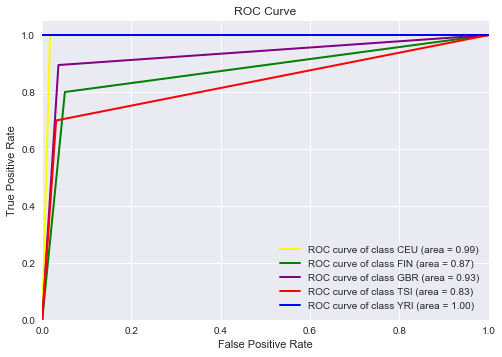

Fold 1
F1-Score:  ['0.96', '0.81', '0.67', '0.69', '1.00']
Accuracy: 82.43%


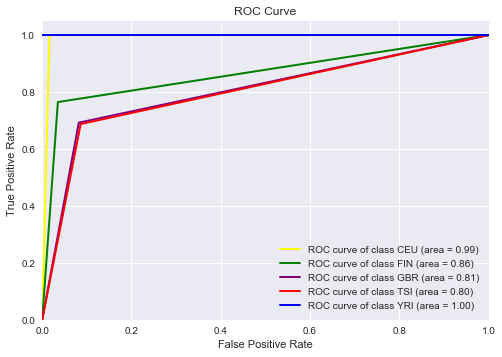

Fold 2
F1-Score:  ['0.97', '0.76', '0.83', '0.85', '1.00']
Accuracy: 87.84%


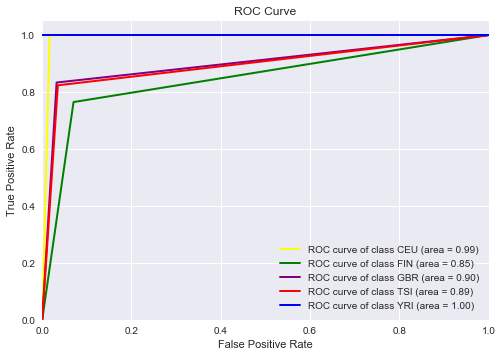

Fold 3
F1-Score:  ['0.86', '0.85', '0.85', '0.67', '0.92']
Accuracy: 82.43%


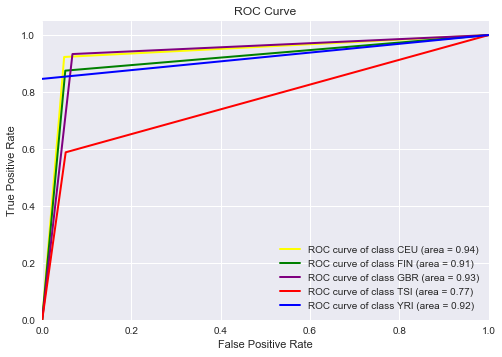

Fold 4
F1-Score:  ['0.94', '0.83', '0.94', '0.85', '0.93']
Accuracy: 90.41%


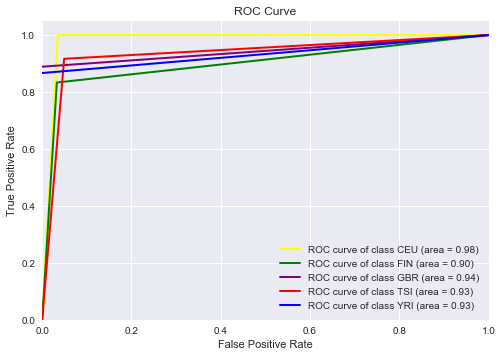

In [445]:
mask = np.all(np.logical_or(dataset_eq_class>1, dataset_eq_class<1), axis=0)
with open('column_mask.pickle', 'wb') as handle:
    pickle.dump(mask, handle, protocol=pickle.HIGHEST_PROTOCOL)
X = np.delete(dataset_eq_class, np.nonzero(mask), axis=1)
Y = sample_vs_label
# split data into train and test sets

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(Y)
label_encoded_y = label_encoder.transform(Y)

seed = 7
test_size = 0.33

skf = KFold(n_splits=5)

accuracy = []
f1_sc = []
i=0
for train_index, test_index in skf.split(X, label_encoded_y):
    print("Fold", i)
    i+=1
#     X_train, X_test = select_features(X[train_index], label_encoded_y[train_index], X[test_index])
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = label_encoded_y[train_index], label_encoded_y[test_index]
    X_train, X_test = select_best_features(X_train, y_train, X_test, 12000, 
                                           'equiv_best_features_'+str(i)+'.pickle')
    # fit model no training data
    model = XGBClassifier()
    model.fit(X_train, y_train)
    # make predictions for test data
    with open('xg_boost_equiv_'+str(i)+'.dat', 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy.append(accuracy_score(y_test, predictions))
    f1_sc.append(f1_score(y_test, predictions, average=None))
    print("F1-Score: ", [ '%.2f' % elem for elem in f1_sc[-1] ])
    print("Accuracy: %.2f%%" % (accuracy[-1] * 100.0))
    draw_roc_curve(y_test, y_pred)

In [446]:
print("Mean F1-Score:\n\t", "\n\t".join(['%s: %.2f%%' % (labels[i], elem) for\
                                          (i, elem) in enumerate(np.mean(f1_sc, axis=0)*100)]))
print("Mean Accuracy: %.2f%%" % (np.mean(accuracy) * 100.0))

Mean F1-Score:
	 CEU: 93.91%
	FIN: 81.18%
	GBR: 83.69%
	TSI: 75.71%
	YRI: 96.90%
Mean Accuracy: 86.46%


# K Fold testing for XGBOOST for TPM Dataset

Fold 0
F1-Score:  ['0.94', '0.90', '0.92', '0.86', '0.96']
Accuracy: 91.89%


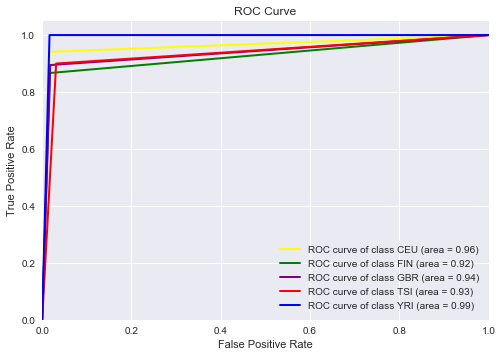

Fold 1
F1-Score:  ['1.00', '0.85', '0.86', '0.71', '1.00']
Accuracy: 87.84%


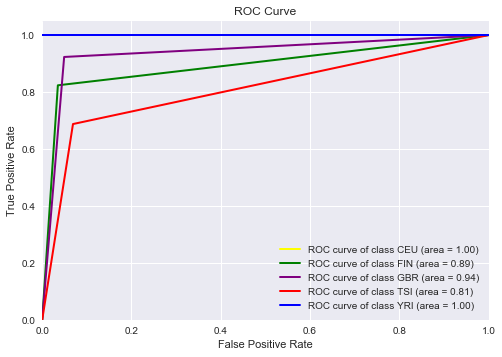

Fold 2
F1-Score:  ['0.93', '0.82', '0.78', '0.81', '0.97']
Accuracy: 86.49%


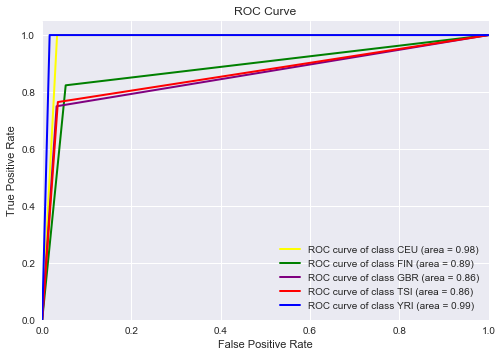

Fold 3
F1-Score:  ['0.96', '0.93', '0.94', '0.88', '0.96']
Accuracy: 93.24%


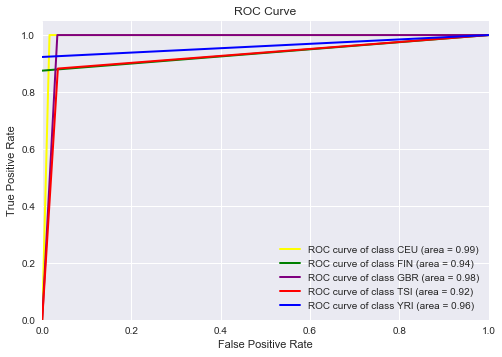

Fold 4
F1-Score:  ['1.00', '0.96', '0.97', '0.87', '0.97']
Accuracy: 95.89%


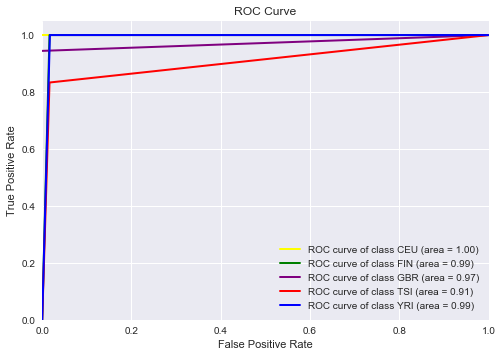

In [447]:
X = dataset
Y = sample_vs_label
# split data into train and test sets

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(Y)
label_encoded_y = label_encoder.transform(Y)

seed = 7
test_size = 0.33

skf = KFold(n_splits=5)

accuracy = []
f1_sc = []
i=0
for train_index, test_index in skf.split(X, label_encoded_y):
    print("Fold", i)
    i+=1
#     X_train, X_test = select_features(X[train_index], label_encoded_y[train_index], X[test_index])
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = label_encoded_y[train_index], label_encoded_y[test_index]
    X_train, X_test = select_best_features(X_train, y_train, X_test, 12000, 
                                           'dataset_best_features'+str(i)+'.pickle')
    # fit model no training data
    model = XGBClassifier()
    model.fit(X_train, y_train)
    # make predictions for test data
    with open('xg_boost_dataset_'+str(i)+'.dat', 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy.append(accuracy_score(y_test, predictions))
    f1_sc.append(f1_score(y_test, predictions, average=None))
    print("F1-Score: ", [ '%.2f' % elem for elem in f1_sc[-1] ])
    print("Accuracy: %.2f%%" % (accuracy[-1] * 100.0))
    draw_roc_curve(y_test, y_pred)

In [448]:
print("Mean F1-Score:\n\t", "\n\t".join(['%s: %.2f%%' % (labels[i], elem) for\
                                          (i, elem) in enumerate(np.mean(f1_sc, axis=0)*100)]))
print("Mean Accuracy: %.2f%%" % (np.mean(accuracy) * 100.0))

Mean F1-Score:
	 CEU: 96.75%
	FIN: 89.24%
	GBR: 89.35%
	TSI: 82.62%
	YRI: 97.12%
Mean Accuracy: 91.07%


***
***
## DEEP LEARNING



In [423]:
def reformat(labels):
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.int32)
  return labels

# Tree-based feature selection

Tree-based estimators (see the sklearn.tree module and forest of trees in the sklearn.ensemble module) can be used to compute feature importances, which in turn can be used to discard irrelevant features (when coupled with the sklearn.feature_selection.SelectFromModel meta-transformer):

In [458]:
def accuracy_predictions(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

# Neural Network
## FC Connected layer
HyperParameters

In [495]:
batch_size = 50
num_hidden_nodes = [800, 10]
num_layers = len(num_hidden_nodes)
dropout_fraction = 0.5
beta_1_value = 1e-3
beta_2_value = 1e-3
learning_step = 1e-3
decay_steps = 1e6
decay_rate = 0.65
k_fold_splits = 5
num_steps = 1200

# Running the neural net
## Training for num_steps epochs

In [496]:
def run_nn(train_dataset, train_labels, test_data, test_labels, valid_dataset, valid_labels):
    num_of_transcripts = train_dataset.shape[1]
    input_size = [num_of_transcripts]+num_hidden_nodes
    graph = tf.Graph()
    with graph.as_default():
        # Input
        tf_train_dataset = tf.placeholder(tf.float32, shape=
                                         (batch_size, None))
        tf_train_labels = tf.placeholder(tf.float32, shape=
                                        (batch_size, num_labels))
        tf_test_data = tf.placeholder(tf.float32, shape=
                                        (None, None))
#         print(tf_test_data.shape)
        global_step = tf.Variable(0)

        # Weights
        weights1 = []
        biases1 = []
        beta1 = []

        for i in range(num_layers):
            weights1.append(tf.Variable(tf.truncated_normal([input_size[i], num_hidden_nodes[i]],\
                                                            stddev=np.sqrt(2.0 / (input_size[i])))))
            biases1.append(tf.Variable(tf.zeros([num_hidden_nodes[i]])))
            beta1.append(beta_1_value)
        biases2 = tf.Variable(tf.zeros([num_labels]))
        weights2 = tf.Variable(tf.truncated_normal([input_size[-1], num_labels],\
                                                   stddev=np.sqrt(2.0 / input_size[-1])))
        beta2 = beta_2_value


        # Training Computation
        lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset,weights1[0]) + biases1[0])
        drop1 = tf.nn.dropout(lay1_train, dropout_fraction)
        for i in range(1, num_layers):
#             print(lay1_train.shape)
#             lay1_train = tf.nn.relu(tf.matmul(drop1, weights1[i]) + biases1[i])
            batch_mean, batch_var = tf.nn.moments(drop1,[0])
            scale = tf.Variable(tf.ones(drop1.shape))
            beta = tf.Variable(tf.zeros(drop1.shape))
            lay1_train = tf.nn.relu(tf.matmul(tf.nn.batch_normalization(\
                                                                        drop1,batch_mean,batch_var,\
                                                                        beta,scale,1e-3), weights1[i])\
                                    + biases1[i])
            drop1 = tf.nn.dropout(lay1_train, dropout_fraction)
        logits = tf.matmul(drop1, weights2) + biases2
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))\
                               + beta2 * tf.nn.l2_loss(weights2)
        for i in range(num_layers):
            loss += beta1[i] * tf.nn.l2_loss(weights1[i]) 

        # Optimizer
        learning_rate = tf.train.exponential_decay(learning_step, global_step, decay_steps, decay_rate, staircase=True)
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

        # Predictions
        train_prediction = tf.nn.softmax(logits)

        lay1_test = tf.nn.relu(tf.matmul(tf_test_data, weights1[0]) + biases1[0])
        for i in range(1, num_layers):
            lay1_test = tf.nn.relu(tf.matmul(lay1_test, weights1[i]) + biases1[i])
        logits_test = tf.matmul(lay1_test, weights2) + biases2
        test_prediction = tf.nn.softmax(logits_test)

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        # Add ops to save and restore all the variables.
        saver = tf.train.Saver()

        minibatch.append(list())
        validation.append(list())
        steps.append(list())
        #     train_dataset = train_sample
        #     train_labels = train_data_label
        for step in range(num_steps):
            offset = (step * batch_size) % \
                     (train_labels.shape[0] - batch_size)

            batch_data = train_dataset[offset:offset + batch_size, :]
            batch_labels = train_labels[offset:offset + batch_size, :]

            feed_dict = {tf_train_dataset: batch_data, \
                         tf_train_labels: batch_labels}
            _, l, predictions = session.run([optimizer, loss, \
                                             train_prediction], feed_dict=feed_dict)

            minibatch[-1].append(accuracy_predictions(predictions, batch_labels))
            validation[-1].append(
                accuracy_predictions(test_prediction.eval(feed_dict={tf_test_data: valid_dataset}), valid_labels))
            steps[-1].append(step)
#             if step % int(num_steps / 2) == 0:
#                 print("Step: %d : Validation accuracy_predictions: %.1f%%" % (step, validation[-1][-1]))
        predicted_labels = test_prediction.eval(feed_dict={tf_test_data : test_data})
        result = accuracy_predictions(predicted_labels, test_labels)
        f1_sc = f1_score(np.argmax(test_labels, 1), np.argmax(predicted_labels, 1), average=None)
        print("Test Accuracy: %.1f%%" % (result))
        print("F1-Score: ", [ '%.2f' % elem for elem in f1_sc ])
    draw_roc_curve(np.argmax(predicted_labels, axis=1), np.argmax(test_labels, axis=1))
#     save_path = saver.save(session, "./model1.ckpt")
#     print("Model saved in file: %s" % save_path)

    return result

In [499]:
# %%time
def run_nn_on_dataset(data):
    result = list()
    i = 0
    accuracy_val = []
    minibatch = list()
    validation = list()
    steps = list()
    skf = KFold(n_splits=k_fold_splits)
    one_hot_samples = reformat(sample_vs_label)
    i=1
    for train_index, test_index in skf.split(data, one_hot_samples):
        print('Fold:', i)
        i=+1
        train_data, test_data = data[train_index], data[test_index]
        train_labels, test_labels = one_hot_samples[train_index], one_hot_samples[test_index]
        train_data, test_data = select_features(train_data, sample_vs_label[train_index], test_data)    
        train_dataset, valid_dataset, train_labels, valid_labels = train_test_split(train_data,\
                                                                                    train_labels, \
                                                                                    test_size=0.2)
        result.append(run_nn(train_dataset, train_labels, test_data, test_labels, valid_dataset, valid_labels))
        

    print("Mean result: %.1f%%" % np.mean(result))
#     for idx in range(len(result)):
#         p = plt.figure()
#         plt.plot(steps[idx], validation[idx], label='validation')
#         plt.plot(steps[idx], minibatch[idx], label='minibatch-acc')
#         plt.legend()
#         plt.show()

Fold: 1
Test Accuracy: 78.4%
F1-Score:  ['0.97', '0.76', '0.72', '0.32', '1.00']


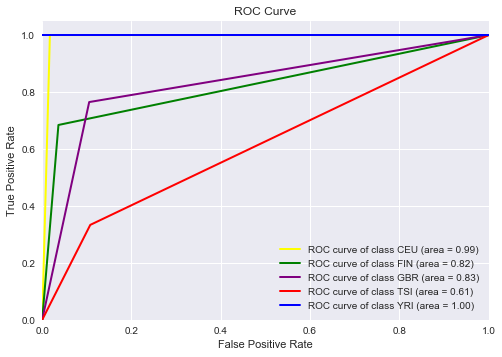

Fold: 1
Test Accuracy: 83.8%
F1-Score:  ['0.85', '0.82', '0.73', '0.81', '0.94']


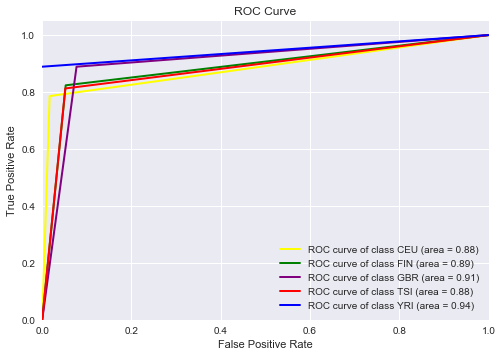

Fold: 1
Test Accuracy: 79.7%
F1-Score:  ['1.00', '0.71', '0.67', '0.73', '0.89']


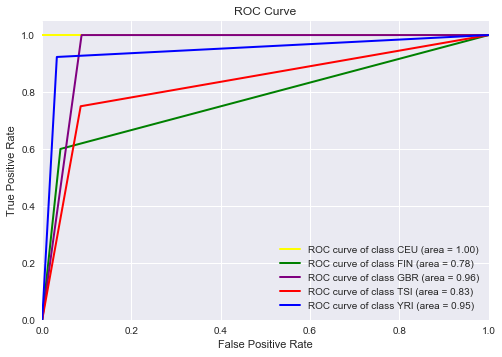

Fold: 1
Test Accuracy: 79.7%
F1-Score:  ['0.77', '0.75', '0.87', '0.71', '0.92']


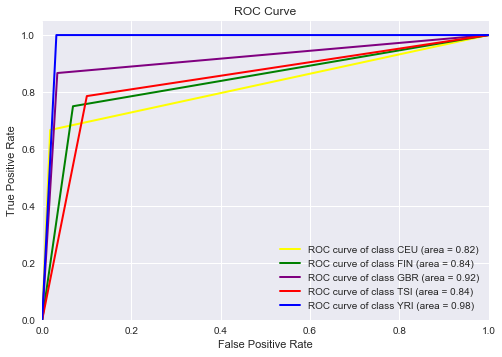

Fold: 1
Test Accuracy: 83.6%
F1-Score:  ['0.91', '0.85', '0.73', '0.67', '1.00']


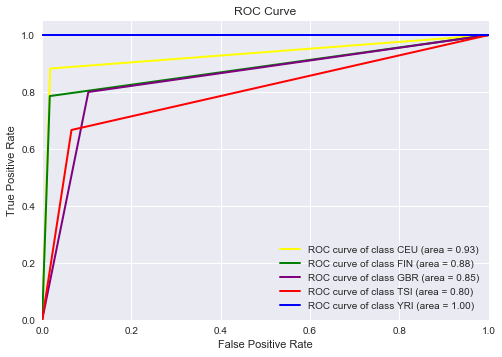

Mean result: 81.0%
CPU times: user 3min 41s, sys: 10.3 s, total: 3min 51s
Wall time: 1min 18s


In [498]:
%%time
run_nn_on_dataset(dataset)

Fold: 1


/Users/anupam/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Test Accuracy: 70.3%
F1-Score:  ['0.82', '0.65', '0.62', '0.40', '0.93']


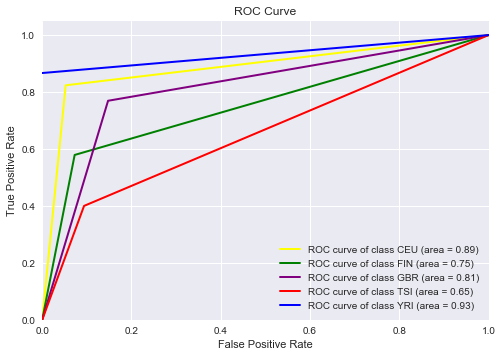

Fold: 1


/Users/anupam/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Test Accuracy: 73.0%
F1-Score:  ['0.87', '0.67', '0.67', '0.48', '0.94']


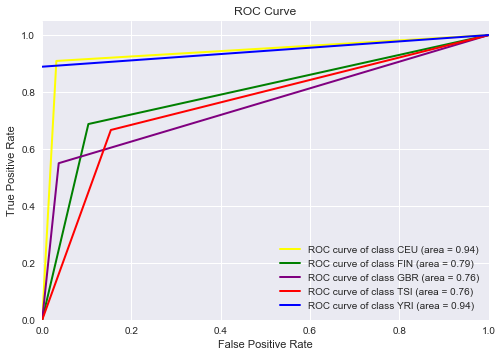

Fold: 1


/Users/anupam/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Test Accuracy: 77.0%
F1-Score:  ['0.93', '0.68', '0.67', '0.65', '0.96']


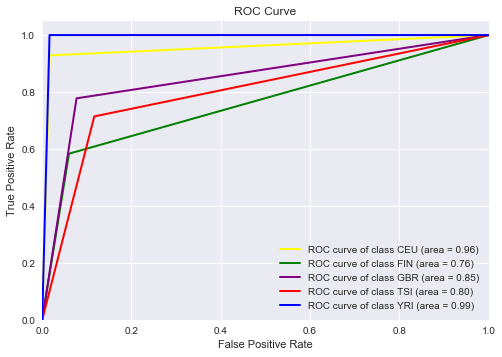

Fold: 1


/Users/anupam/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Test Accuracy: 71.6%
F1-Score:  ['0.82', '0.65', '0.69', '0.59', '0.92']


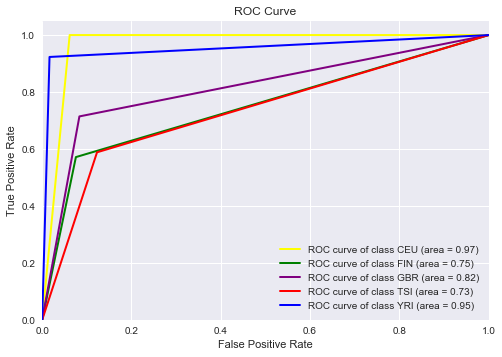

Fold: 1


/Users/anupam/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Test Accuracy: 72.6%
F1-Score:  ['0.94', '0.71', '0.35', '0.60', '0.93']


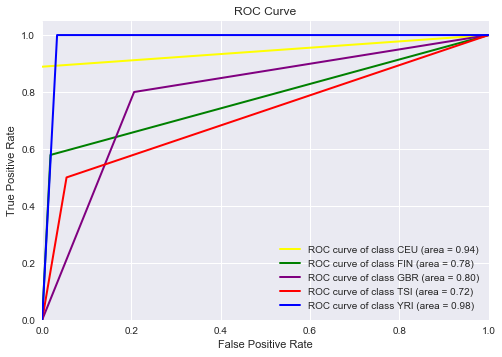

Mean result: 72.9%
CPU times: user 4min 33s, sys: 3min 1s, total: 7min 35s
Wall time: 6min 7s


In [500]:
%%time
run_nn_on_dataset(dataset_eq_class)